In [14]:
import numpy as np
import matplotlib.pyplot as plt
import glob, h5py, natsort, os
import scipy.signal as sig
import scipy.optimize as opt

In [15]:
data_path_calib = "/Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration"

calib_files = glob.glob(data_path_calib + "/20250731_11e*.hdf5")

In [16]:
print("Found calibration files: ", calib_files)

Found calibration files:  ['/Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_0.hdf5', '/Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_1.hdf5', '/Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_2.hdf5', '/Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_3.hdf5', '/Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_4.hdf5']


In [17]:
nfft_pts = 2**22 ## number of points in the fft. We are sampling at 500 kHz, so 2**22 points is about 8 seconds of data

Processing file:  /Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_0.hdf5
Processing file:  /Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_1.hdf5
Processing file:  /Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_2.hdf5
Processing file:  /Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_3.hdf5
Processing file:  /Volumes/DATA/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_4.hdf5
Used a total of  35.0  PSDs to compute the calibration spectrum.


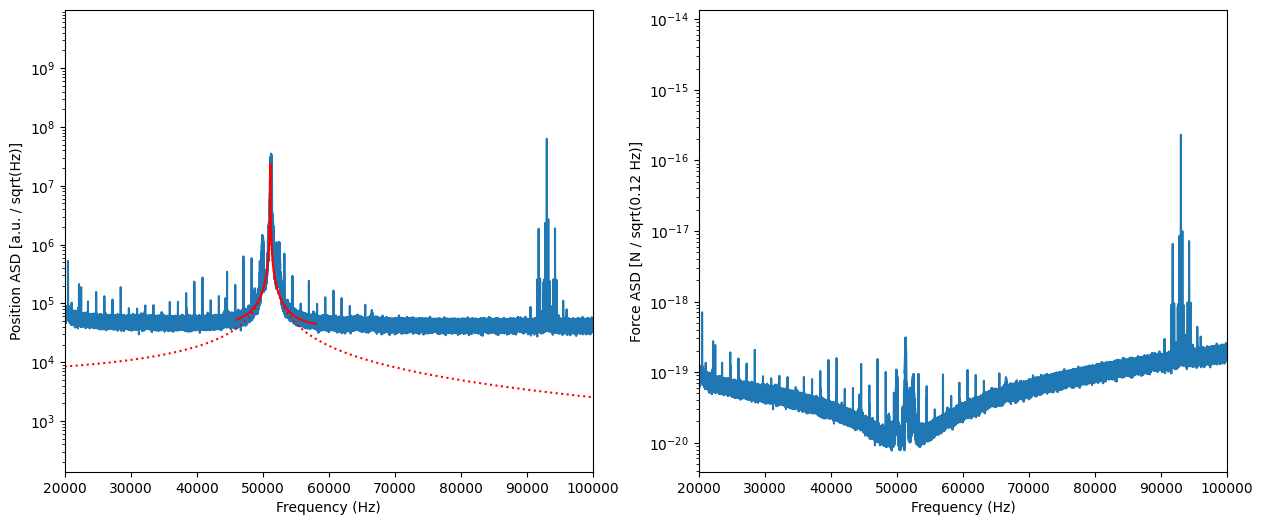

In [18]:
## first make the calibration
redo_calib = True

if(redo_calib):

    npsds = 0

    for file in calib_files:
        print("Processing file: ", file)
        with h5py.File(file, 'r') as f:
            curr_data = f['data']['channel_d']

            fs = 1/f['data'].attrs['delta_t']

            ## want to get the thing into units of N per sqrt(some freq bin), where the freq bin is the same for the 
            ## calibration and the data

            nchunks = len(curr_data) // nfft_pts

            for i in range(nchunks):
                curr_chunk = curr_data[(i*nfft_pts):((i+1)*nfft_pts)]

                ## do the fft
                f_curr_chunk = np.fft.rfft(curr_chunk, n=nfft_pts)

                if(npsds == 0):
                    calib_spectrum_psd_uncal = np.abs(f_curr_chunk)**2
                else:
                    calib_spectrum_psd_uncal += np.abs(f_curr_chunk)**2

                npsds += 1.0
    
    calib_spectrum_psd = calib_spectrum_psd_uncal / npsds
    print("Used a total of ", npsds, " PSDs to compute the calibration spectrum.")
    
    freqs = np.fft.rfftfreq(nfft_pts, d=1/fs)

    np.savez("calibration_spectrum.npz", freqs=freqs, calib_spectrum_psd=calib_spectrum_psd)

else:
    calib_data = np.load("calibration_spectrum.npz")
    freqs = calib_data['freqs']
    calib_spectrum_psd = calib_data['calib_spectrum_psd']

## first fit the resonance to get the resonance frequency and damping
fit_range = [46e3, 58e3] ## Hz
fit_mask = (freqs >= fit_range[0]) & (freqs <= fit_range[1])
def lorentzian(f, f0, gamma, A, C):
    omega = 2 * np.pi * f
    omega0 = 2 * np.pi * f0
    return A / ((omega0**2 - omega**2)**2 + (gamma * omega)**2) + C

p0 = [52e3, 1e3, 1e30, 1e10]  # Initial guess for [f0, gamma, A]
bp, bc = opt.curve_fit(lorentzian, freqs[fit_mask], calib_spectrum_psd[fit_mask], p0=p0, sigma=0.01* calib_spectrum_psd[fit_mask])

plt_xlims = [20e3, 100e3]

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.semilogy(freqs, np.sqrt(calib_spectrum_psd), label='Calibration Spectrum PSD')
plt.plot(freqs[fit_mask], np.sqrt(lorentzian(freqs[fit_mask], *bp)), 'r', label='Lorentzian Fit')
plt.plot(freqs, np.sqrt(lorentzian(freqs, bp[0], bp[1], bp[2], 0)), 'r:', label='Lorentzian Fit')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Position ASD [a.u. / sqrt(Hz)]')
plt.xlim(plt_xlims)

## now we use the calibration factor that gives us the correct number of newtons of force
## in a given bandwidth fft bin

## first the bin size
bin_size = freqs[1] - freqs[0]  # Hz

## we are playing 2.5 Vpp, with field factor 106 V/m per V
## we also have eleven elementary charges, so the force amplitude should be 
## 106 V/m * 2.5/2 * 11 elementary charges = 2.3e-16 N

actual_force = 2.3e-16  # N, this is the force amplitude we expect for the calibration


force_asd_uncal = np.sqrt(calib_spectrum_psd/lorentzian(freqs, bp[0], bp[1], bp[2], 0))
calib_spec_for_max = 1.0*force_asd_uncal  # make a copy of the force ASD for the max calculation
calib_spec_for_max[(freqs < 90e3)|(freqs > 100e3)] = 0.0  # zero out the calibration spectrum outside the range of interest
drive_force = np.max(calib_spec_for_max)
force_calibration_factor = (actual_force / drive_force)  # N per sqrt( bin size)

cal_vs_freq = force_calibration_factor/np.sqrt(lorentzian(freqs, bp[0], bp[1], bp[2], 0)) ## multiply by the asd from the fft to get calibrated asd

plt.subplot(1,2,2)
plt.semilogy(freqs, cal_vs_freq * np.sqrt(calib_spectrum_psd))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Force ASD [N / sqrt(%.2f Hz)]'%bin_size)
plt.xlim(plt_xlims)
#plt.gca().set_yscale('linear')
#plt.xlim(92.9e3, 93.1e3)
#plt.ylim(0, 3e-16)

plt.show()

In [19]:
data_path = "/Volumes/DATA/lorentz_force/sphere_20250708/20250804_2e-8mbar_newsamp"

background_files = natsort.natsorted(glob.glob(data_path + "/20250804_m350e_79khz_100vpp_nob_*.hdf5"))
positive_files = natsort.natsorted(glob.glob(data_path + "/20250804_m350e_79khz_100vpp_withb_[0-9]*.hdf5"))
negative_files = natsort.natsorted(glob.glob(data_path + "/20250804_m350e_79khz_100vpp_withb_flipped_*.hdf5"))

In [20]:
def get_idx_list(flist):
    idx_list = []
    for fname in flist:
        idx_list.append(float(fname.split("_")[-1].split(".")[0]))
    return idx_list

In [21]:
background_files_idx_list = get_idx_list(background_files)
positive_files_idx_list = get_idx_list(positive_files)
negative_files_idx_list = get_idx_list(negative_files) 

Found N background files:  7308
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already exists, skipping...
Data file already 

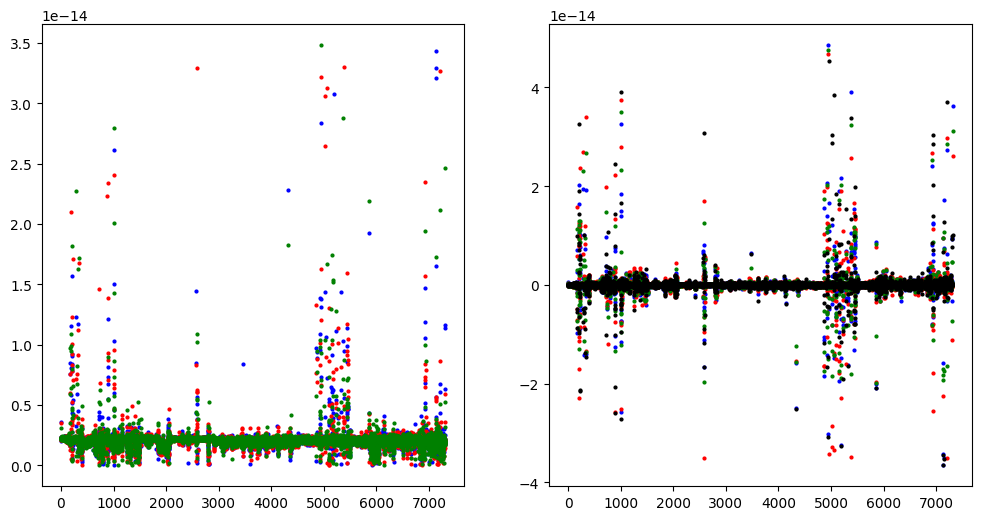

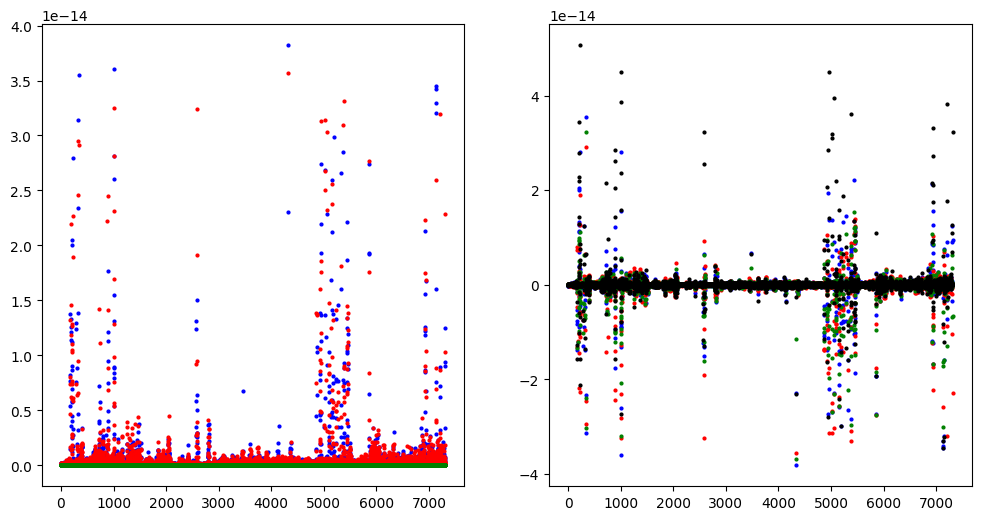

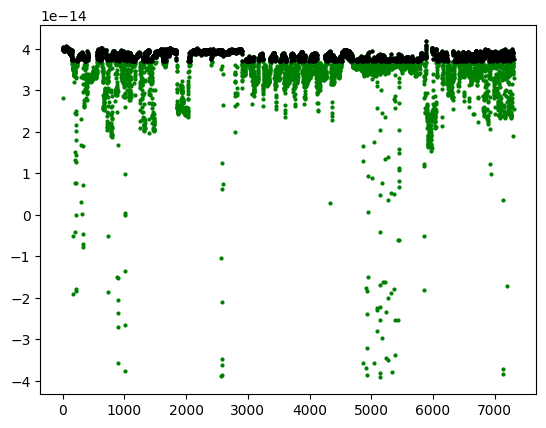

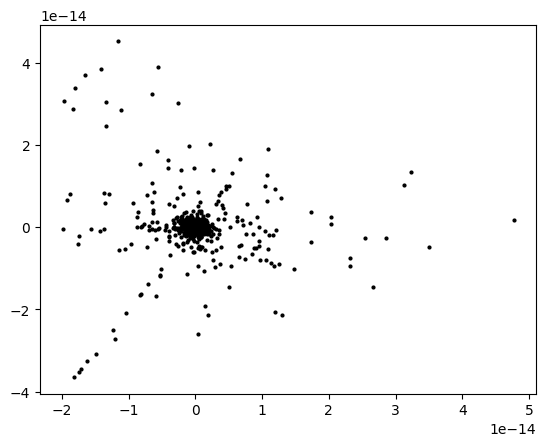

In [22]:
make_plots = False 
remake_data = True

xvals_for_plot = [78.98e3, 79.02e3]  # Hz, range for the plots
yvals_for_plot = [1e-20, 1e-13]
#xvals_for_plot = [50e3, 85e3]  # Hz, range for the plots

data_path = 'data/20250804/'

print("Found N background files: ", len(background_files))

if(remake_data):

    for bg in background_files:

        if(make_plots):
            spec_fig = plt.figure(figsize=(18, 5))
            angle_fig = plt.figure(figsize=(12,5))

        bg_idx = float(bg.split("_")[-1].split(".")[0])

        if(os.path.isfile(data_path + "processed_%d.npz"%bg_idx)):
            print("Data file already exists, skipping...")
            continue

        if(bg_idx not in positive_files_idx_list):
            print("No positive drive file for background index: ", bg_idx)
            continue
        if(bg_idx not in negative_files_idx_list):
            print("No negative drive file for background index: ", bg_idx)
            continue
        pd = positive_files[positive_files_idx_list.index(bg_idx)]
        nd = negative_files[negative_files_idx_list.index(bg_idx)]

        pd_idx = float(pd.split("_")[-1].split(".")[0])
        nd_idx = float(nd.split("_")[-1].split(".")[0])

        if((bg_idx != pd_idx) | (bg_idx != nd_idx)):
            print("Background and positive drive files do not match: ", bg, " and ", pd, " and ", nd)
            continue

        #if(bg_idx > 100): break
        if(bg_idx % 50 == 0): 
            print("Processing background index: ", bg_idx)

        ## first the BG file
        with h5py.File(bg, 'r') as f:
            curr_data = f['data']['channel_d']
            curr_drive = f['data']['channel_g']
            fs = 1/f['data'].attrs['delta_t']

            ## trim to nearest power of two
            bg_data_fft = np.fft.rfft(curr_data[(-nfft_pts):])
            drive_fft = np.fft.rfft(curr_drive[(-nfft_pts):])

        rotated_data_bg = bg_data_fft/(drive_fft/np.abs(drive_fft))  # rotate the data by the drive phase
        extra_rotation_corr = rotated_data_bg/np.abs(rotated_data_bg)
        bg_rotated_data_bg = rotated_data_bg/extra_rotation_corr
        max_freq_index = np.argmax(np.abs(drive_fft))
        #freqs = np.fft.rfftfreq(nfft_pts, d=1/fs)
        #print("Found max at frequency: ", freqs[max_freq_index], " Hz")

        if(make_plots):
            plt.figure(angle_fig.number)
            plt.subplot(1,2,1)
            plt.plot([0, (np.real(bg_data_fft)/np.abs(bg_data_fft))[max_freq_index]], [0, (np.imag(bg_data_fft)/np.abs(bg_data_fft))[max_freq_index]], 'ro-', ms=3, label='BG Data FFT')
            plt.plot([0, (np.real(drive_fft)/np.abs(drive_fft))[max_freq_index]], [0, (np.imag(drive_fft)/np.abs(drive_fft))[max_freq_index]], 'bo-', ms=3, label='BG Data FFT')
            plt.subplot(1,2,2)
            plt.plot([0, (np.real(rotated_data_bg)/np.abs(rotated_data_bg))[max_freq_index]], [0, (np.imag(rotated_data_bg)/np.abs(rotated_data_bg))[max_freq_index]], 'bo-', ms=3, label='BG Data FFT')
            plt.plot([0, (np.real(bg_rotated_data_bg)/np.abs(bg_rotated_data_bg))[max_freq_index]], [0, (np.imag(bg_rotated_data_bg)/np.abs(rotated_data_bg))[max_freq_index]], 'bs-', ms=3, label='BG Data FFT')


        if(make_plots):
            plt.figure(spec_fig.number)
            plt.subplot(1,3,1)
            plt.semilogy(freqs, np.abs(data_fft)* cal_vs_freq)
            plt.semilogy(freqs, np.abs(np.imag(rotated_data_bg))* cal_vs_freq, label='Rotated Data')
            plt.semilogy(freqs, np.abs(np.imag(bg_rotated_data_bg))* cal_vs_freq, label='Rotated Data')
            plt.xlim(xvals_for_plot)
            plt.ylim(yvals_for_plot)

        ## now the positive drive file
        with h5py.File(pd, 'r') as f:
            curr_data = f['data']['channel_d']
            curr_drive = f['data']['channel_g']

            ## trim to nearest power of two
            data_fft = np.fft.rfft(curr_data[(-nfft_pts):])
            drive_fft = np.fft.rfft(curr_drive[(-nfft_pts):])

        rotated_data_pd = data_fft/(drive_fft/np.abs(drive_fft))
        bg_rotated_data_pd = rotated_data_pd/extra_rotation_corr

        if(make_plots):
            plt.figure(angle_fig.number)
            plt.subplot(1,2,1)
            plt.plot([0, (np.real(data_fft)/np.abs(data_fft))[max_freq_index]], [0, (np.imag(data_fft)/np.abs(data_fft))[max_freq_index]], 'mo-', ms=3, label='BG Data FFT')
            plt.plot([0, (np.real(drive_fft)/np.abs(drive_fft))[max_freq_index]], [0, (np.imag(drive_fft)/np.abs(drive_fft))[max_freq_index]], 'co-', ms=3, label='BG Data FFT')
            plt.subplot(1,2,2)
            plt.plot([0, (np.real(rotated_data_pd)/np.abs(rotated_data_pd))[max_freq_index]], [0, (np.imag(rotated_data_pd)/np.abs(rotated_data_pd))[max_freq_index]], 'co-', ms=3, label='BG Data FFT')
            plt.plot([0, (np.real(bg_rotated_data_pd)/np.abs(bg_rotated_data_pd))[max_freq_index]], [0, (np.imag(bg_rotated_data_pd)/np.abs(rotated_data_pd))[max_freq_index]], 'cs-', ms=3, label='BG Data FFT')


        ## now the negative drive file
        with h5py.File(nd, 'r') as f:
            curr_data = f['data']['channel_d']
            curr_drive = f['data']['channel_g']

            ## trim to nearest power of two
            data_fft = np.fft.rfft(curr_data[(-nfft_pts):])
            drive_fft = np.fft.rfft(curr_drive[(-nfft_pts):])

        rotated_data_nd = data_fft/(drive_fft/np.abs(drive_fft))
        bg_rotated_data_nd = rotated_data_nd/extra_rotation_corr

        if(make_plots):
            plt.figure(angle_fig.number)
            plt.subplot(1,2,1)
            plt.plot([0, (np.real(data_fft)/np.abs(data_fft))[max_freq_index]], [0, (np.imag(data_fft)/np.abs(data_fft))[max_freq_index]], 'go-', ms=3, label='BG Data FFT')
            plt.plot([0, (np.real(drive_fft)/np.abs(drive_fft))[max_freq_index]], [0, (np.imag(drive_fft)/np.abs(drive_fft))[max_freq_index]], 'ko-', ms=3, label='BG Data FFT')
            plt.subplot(1,2,2)
            plt.plot([0, (np.real(rotated_data_nd)/np.abs(rotated_data_nd))[max_freq_index]], [0, (np.imag(rotated_data_nd)/np.abs(rotated_data_nd))[max_freq_index]], 'ko-', ms=3, label='BG Data FFT')
            plt.plot([0, (np.real(bg_rotated_data_nd)/np.abs(bg_rotated_data_nd))[max_freq_index]], [0, (np.imag(bg_rotated_data_nd)/np.abs(rotated_data_nd))[max_freq_index]], 'ks-', ms=3, label='BG Data FFT')


        pos_drive_val = np.abs(np.imag(rotated_data_pd)*cal_vs_freq)[max_freq_index]
        neg_drive_val = np.abs(np.imag(rotated_data_nd)*cal_vs_freq)[max_freq_index]
        bg_drive_val = np.abs(np.imag(rotated_data_bg)*cal_vs_freq)[max_freq_index]
        sub_val = (np.imag(rotated_data_pd - rotated_data_nd)*cal_vs_freq)[max_freq_index]
        pos_sub_val = (np.imag(rotated_data_pd - rotated_data_bg)*cal_vs_freq)[max_freq_index]
        neg_sub_val = (np.imag(rotated_data_nd - rotated_data_bg)*cal_vs_freq)[max_freq_index]
        sum_val = (np.imag(0.5*(rotated_data_pd + rotated_data_nd) - rotated_data_bg)*cal_vs_freq)[max_freq_index]

        bg_pos_drive_val = np.abs(np.imag(bg_rotated_data_pd)*cal_vs_freq)[max_freq_index]
        bg_neg_drive_val = np.abs(np.imag(bg_rotated_data_nd)*cal_vs_freq)[max_freq_index]
        bg_bg_drive_val = np.abs(np.imag(bg_rotated_data_bg)*cal_vs_freq)[max_freq_index]
        bg_sub_val = (np.imag(bg_rotated_data_pd - bg_rotated_data_nd)*cal_vs_freq)[max_freq_index]
        bg_pos_sub_val = (np.imag(bg_rotated_data_pd - bg_rotated_data_bg)*cal_vs_freq)[max_freq_index]
        bg_neg_sub_val = (np.imag(bg_rotated_data_nd - bg_rotated_data_bg)*cal_vs_freq)[max_freq_index]
        bg_sum_val = (np.imag(0.5*(bg_rotated_data_pd + bg_rotated_data_nd) - bg_rotated_data_bg)*cal_vs_freq)[max_freq_index]

        pos_drive_mag = (np.real(rotated_data_pd)*cal_vs_freq)[max_freq_index]
        neg_drive_mag = (np.real(rotated_data_nd)*cal_vs_freq)[max_freq_index]
        bg_drive_mag = (np.real(rotated_data_bg)*cal_vs_freq)[max_freq_index]


        curr_data_out = [bg_idx, pos_drive_val, neg_drive_val, bg_drive_val, pos_sub_val, neg_sub_val, sub_val, sum_val, 
                         bg_pos_drive_val, bg_neg_drive_val, bg_bg_drive_val, bg_pos_sub_val, bg_neg_sub_val, bg_sub_val, bg_sum_val,
                         pos_drive_mag, neg_drive_mag, bg_drive_mag]
        
        np.savez(data_path + "processed_%d.npz"%bg_idx, data=curr_data_out)

        if(make_plots):
            plt.figure(spec_fig.number)
            plt.subplot(1,3,2)
            plt.semilogy(freqs, np.abs(data_fft) * cal_vs_freq)
            plt.semilogy(freqs, np.abs(np.imag(rotated_data_pd)) * cal_vs_freq, label='Rotated Data (pos)')
            plt.xlim(xvals_for_plot)
            plt.ylim(yvals_for_plot)

            plt.subplot(1,3,3)
            plt.semilogy(freqs, np.abs(np.imag(rotated_data_pd)) * cal_vs_freq, label='Rotated Data BG')
            plt.semilogy(freqs, np.abs(np.imag(rotated_data_bg)) * cal_vs_freq, label='Rotated Data BG')
            plt.semilogy(freqs, np.abs(np.imag(rotated_data_bg) - np.imag(rotated_data_pd)) * cal_vs_freq, label='Rotated Data BG')
            plt.xlim(xvals_for_plot)
            plt.ylim(yvals_for_plot)

            plt.show()


    data_out = []
    for bg in background_files:
        bg_idx = float(bg.split("_")[-1].split(".")[0])
        if(os.path.isfile(data_path + "processed_%d.npz"%bg_idx)):
            with np.load(data_path + "processed_%d.npz"%bg_idx) as f:
                data_out.append(f['data'])
        else:
            print("No data for background index: ", bg_idx)

    data = np.array(data_out)
    np.savez("sphere_20250804_data.npz", data=data)
else:
    data = np.load("sphere_20250804_data.npz")['data']

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(data[:,0], data[:,1], 'bo', ms=2, label='Positive Drive')
plt.plot(data[:,0], data[:,2], 'ro', ms=2, label='Negative Drive')
plt.plot(data[:,0], data[:,3], 'go', ms=2, label='Background')

plt.subplot(1,2,2)
plt.plot(data[:,0], data[:,4], 'bo', ms=2, label='Pos BG Sub')
plt.plot(data[:,0], data[:,5], 'ro', ms=2, label='Neg BG Sub')
plt.plot(data[:,0], data[:,7], 'go', ms=2, label='Sum BG sub')
plt.plot(data[:,0], data[:,6], 'ko', ms=2, label='Diff BG sub')

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(data[:,0], data[:,8], 'bo', ms=2, label='Positive Drive')
plt.plot(data[:,0], data[:,9], 'ro', ms=2, label='Negative Drive')
plt.plot(data[:,0], data[:,10], 'go', ms=2, label='Background')

plt.subplot(1,2,2)
plt.plot(data[:,0], data[:,11], 'bo', ms=2, label='Pos BG Sub')
plt.plot(data[:,0], data[:,12], 'ro', ms=2, label='Neg BG Sub')
plt.plot(data[:,0], data[:,14], 'go', ms=2, label='Sum BG sub')
plt.plot(data[:,0], data[:,13], 'ko', ms=2, label='Diff BG sub')

plt.figure()
#plt.plot(data[:,0], data[:,15], 'bo', ms=2, label='Pos mag')
#plt.plot(data[:,0], data[:,16], 'ro', ms=2, label='Neg mag')
cut_pts = data[:,17] > 3.7e-14 #3.7e-14
plt.plot(data[:,0], data[:,17], 'go', ms=2, label='Bg mag')
plt.plot(data[cut_pts,0], data[cut_pts,17], 'ko', ms=2, label='Bg mag')

plt.figure()
plt.plot(data[:,7], data[:,6], 'ko', ms=2, label='Diff BG sub')

plt.show()



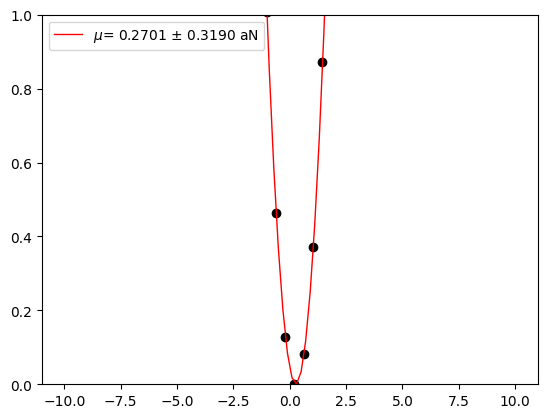

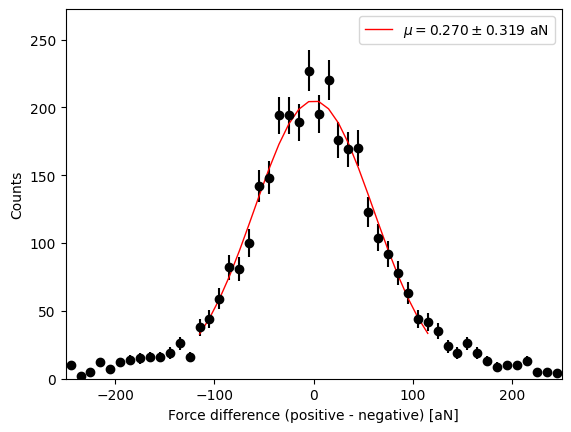

In [44]:
idx_to_use = 6

smoothing_fac = 10
smoothed_data = sig.savgol_filter(data[cut_pts,idx_to_use], smoothing_fac, 3)

#hh, be = np.histogram(data[cut_pts,idx_to_use]*1e18, bins=100, range=[-1e3, 1e3])
hh, be = np.histogram(smoothed_data*1e18, bins=200, range=[-1e3, 1e3])


bc = (be[1:] + be[:-1]) / 2.0

def gaussian(x, mu, sigma, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

fit_pts = (bc > -0.125e3) & (bc < 0.125e3)


## profile over the mean
mean_list = np.linspace(-10,10,50)
chi2_list = np.zeros_like(mean_list)
for midx, mu in enumerate(mean_list):
    gauss_fixed = lambda x, sigma, A: gaussian(x, mu, sigma, A)
    popt, pcov = opt.curve_fit(gauss_fixed, bc[fit_pts], 1.0*hh[fit_pts], p0=[0.1e3, 100], sigma=np.sqrt(hh[fit_pts]))
    chi2 = np.sum(((hh[fit_pts] - gauss_fixed(bc[fit_pts], *popt)) / np.sqrt(hh[fit_pts]))**2)
    chi2_list[midx] = chi2

chi2_list -= np.min(chi2_list)

quadfun = lambda x, a, x0: a * (x-x0)**2

plt.figure()
plt.plot(mean_list, chi2_list, 'ko')
p, _ = opt.curve_fit(quadfun, mean_list, chi2_list)
xvals = np.linspace(mean_list[0], mean_list[-1], 100)
sigma = 1/(4*np.sqrt(p[0]))
plt.plot(xvals, quadfun(xvals, *p), 'r-', label='$\mu$= %.4f $\pm$ %.4f aN'%(p[1], sigma), lw=1)
plt.ylim(0,1)
plt.legend()

spars = [0, 0.1e3, 100]
popt, pcov = opt.curve_fit(gaussian, bc[fit_pts], 1.0*hh[fit_pts], p0=spars, sigma=np.sqrt(hh[fit_pts]))

plt.figure()
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt = 'ko')
plt.plot(bc[fit_pts], gaussian(bc[fit_pts], *popt), 'r-', label='$\mu = %.3f \pm %.3f$ aN'%(p[1], sigma), lw=1)
plt.xlabel("Force difference (positive - negative) [aN]")
plt.ylabel("Counts")
plt.ylim(0, 1.2* np.max(hh))
yy = plt.ylim()
#plt.vlines([3.1], yy[0], yy[1], color='k', ls='--', lw=1, label='2$F_{lorentz}$ = 31 zN')
plt.xlim(-250, 250)
plt.legend()
plt.show()


plt.show()

Final median:  -9.745939650424791e-19  aN
Final std:  1.456649789544575e-18  aN


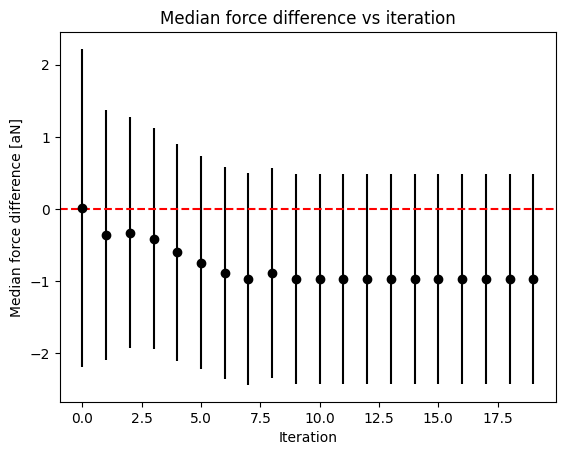

In [24]:
## alternative method where we iteratively throw out tails until the median stabilizes:

nsig = 2.5

median_list = []
median_err_list = []
last_std = 5e-16
last_median = 0
for i in range(20):

    center_pts = np.abs(data[:,idx_to_use] - last_median) < nsig * last_std

    last_median = np.median(data[cut_pts&center_pts,idx_to_use])
    last_std = np.std(data[cut_pts&center_pts,idx_to_use])   

    median_list.append(last_median)
    median_err_list.append(last_std/np.sqrt(np.sum(center_pts)))

median_list = np.array(median_list)
median_err_list = np.array(median_err_list)

print("Final median: ", last_median, " aN")
print("Final std: ", median_err_list[-1], " aN")

plt.figure()
plt.errorbar(np.arange(len(median_list)), median_list*1e18, yerr=median_err_list*1e18, fmt='ko')
plt.xlabel("Iteration")
plt.ylabel("Median force difference [aN]")
plt.axhline(0, color='r', ls='--')
plt.title("Median force difference vs iteration")
plt.show()
